In [1]:
# Import 
from DimCuantifier import DimCuantifier

import gensim
import numpy as np

from gensim.scripts.glove2word2vec import glove2word2vec
from tqdm.notebook import tqdm
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity    # Reemplzar por scipy_cosine
from scipy.spatial.distance import cosine as scipy_cosine
from numpy import linalg


%load_ext autotime

time: 0 ns (started: 2021-12-18 22:17:28 -03:00)


# Set model

In [2]:
def generate_norm_embedding(model, output_path):
    temp_file = open(output_path,'wb')
    temp_file.write(str.encode(str(len(model.key_to_index))+' '+str(model.vector_size)+'\n'))
    
    for each_word in tqdm(model.key_to_index):
        temp_file.write(str.encode(each_word+' '))
        temp_file.write(model[each_word]/linalg.norm(model[each_word]))
        temp_file.write(str.encode('\n'))
    
    temp_file.close()

time: 0 ns (started: 2021-12-18 22:17:28 -03:00)


In [3]:
norm_glove_6B = 'normalized_glove.6B.300d.mod'
norm_glove_42B = 'normalized_glove.42B.300d.mod'

time: 0 ns (started: 2021-12-18 22:17:28 -03:00)


In [4]:
current_model = gensim.models.KeyedVectors.load_word2vec_format(norm_glove_42B,binary=True)

time: 45.5 s (started: 2021-12-18 22:17:28 -03:00)


# Set Antonym List

In [5]:
def list_antonym_tuple(file_list, model):
    list_antonym = []
    for file in file_list:
        with open(file) as fp:
            for line in fp:
                parts = line.split()
                if parts[3]=='antonym':
                    word1 = parts[0].split('-')[0]
                    word2 = parts[1].split('-')[0]
                    if word1 in model and word2 in model:
                        list_antonym.append((word1.strip().lower(), word2.strip().lower()))
    return list_antonym

def select_antonym_list(list_antonym):
    # Add the value of cosine similarity between two polar words
    all_similarity = defaultdict(dict)
    for each_pair in tqdm(list_antonym):
        word1 = min(each_pair[0], each_pair[1])
        word2 = max(each_pair[0], each_pair[1])
        all_similarity[word1][word2] = abs(cosine_similarity([current_model[word1]],[current_model[word2]])[0][0])

    # Select the less value for cosine similiraty for a polar word to a word
    final_antonym_list = []
    for index_counter, each_key in enumerate(tqdm(all_similarity)):
        listofTuples = sorted(all_similarity[each_key].items() ,  key=lambda x: x[1])
        final_antonym_list.append((each_key, listofTuples[0][0]))
    
    return final_antonym_list

time: 47 ms (started: 2021-12-18 22:18:13 -03:00)


In [6]:
list_antonym = list_antonym_tuple(['..\POLAR\POLAR-master\POLAR-master\Antonym_sets\LenciBenotto.val',
                                   '..\POLAR\POLAR-master\POLAR-master\Antonym_sets\LenciBenotto.test',
                                   '..\POLAR\POLAR-master\POLAR-master\Antonym_sets\EVALution.val',
                                   '..\POLAR\POLAR-master\POLAR-master\Antonym_sets\EVALution.test'],
                                    current_model)

list_antonym = list(dict.fromkeys(list_antonym).keys())

time: 125 ms (started: 2021-12-18 22:18:13 -03:00)


In [7]:
final_antonym_list = select_antonym_list(list_antonym)
final_antonym_list

  0%|          | 0/3110 [00:00<?, ?it/s]

  0%|          | 0/1468 [00:00<?, ?it/s]

[('exclude', 'inscribe'),
 ('assertion', 'meek'),
 ('beginning', 'terminal'),
 ('lop', 'secure'),
 ('libertine', 'pastor'),
 ('hook', 'pocket'),
 ('orbital', 'stable'),
 ('disprove', 'document'),
 ('biological', 'psychological'),
 ('preparedness', 'unreadiness'),
 ('dehydration', 'saturation'),
 ('biologic', 'geologic'),
 ('accessibility', 'hindrance'),
 ('agree', 'crab'),
 ('beautify', 'misconstrue'),
 ('lump', 'separate'),
 ('double', 'indivisible'),
 ('forgetting', 'training'),
 ('determined', 'irresolute'),
 ('still', 'velocity'),
 ('shield', 'unshield'),
 ('guess', 'tabulate'),
 ('iconic', 'undefined'),
 ('caress', 'punch'),
 ('compressor', 'stretcher'),
 ('allude', 'specify'),
 ('birthplace', 'cemetery'),
 ('corrupt', 'sanctify'),
 ('actor', 'cameraman'),
 ('knowledgeable', 'naivety'),
 ('screech', 'talk'),
 ('hedge', 'squander'),
 ('aggregate', 'scatter'),
 ('constrict', 'free'),
 ('break', 'construct'),
 ('descriptive', 'normative'),
 ('inscribe', 'smooth'),
 ('bulge', 'depress

time: 1.66 s (started: 2021-12-18 22:18:14 -03:00)


# Create Object

In [8]:
DC = DimCuantifier(current_model, final_antonym_list)

time: 16 ms (started: 2021-12-18 22:18:15 -03:00)


In [9]:
DC.get_n_pair_antonym()

1468

time: 0 ns (started: 2021-12-18 22:18:15 -03:00)


# Set Corpus

In [10]:
toy_example = [
    'i like red candy', 
    'i like green candy', 
    'candy is good and red is the best',
    'candy is bad for you',
]
for i, document in enumerate(toy_example):
    toy_example[i] = document.split()

time: 0 ns (started: 2021-12-18 22:18:15 -03:00)


In [11]:
DC.set_corpus(toy_example)

print(DC.get_corpus())
print(DC.get_word_frequency_dictionary())
print(DC.get_semantic_axis_vector_list())

[['i', 'like', 'red', 'candy'], ['i', 'like', 'green', 'candy'], ['candy', 'is', 'good', 'and', 'red', 'is', 'the', 'best'], ['candy', 'is', 'bad', 'for', 'you']]
Counter({'candy': 4, 'is': 3, 'i': 2, 'like': 2, 'red': 2, 'green': 1, 'good': 1, 'and': 1, 'the': 1, 'best': 1, 'bad': 1, 'for': 1, 'you': 1})
[[ 0.12662847 -0.08837156 -0.14503695 ... -0.11319511 -0.02636484
  -0.02384561]
 [-0.03927298 -0.12916106  0.01369164 ... -0.06528507  0.00735458
  -0.00648679]
 [-0.12753984  0.03791568 -0.00220987 ... -0.05523922  0.00911561
   0.08542319]
 ...
 [-0.01947509  0.09505085 -0.02595011 ...  0.06559949  0.01845428
  -0.02085909]
 [ 0.03859663 -0.06377355  0.12792414 ... -0.01005064  0.08698562
   0.05311072]
 [ 0.05340383 -0.0496843  -0.01196253 ... -0.01027349  0.09272961
   0.00462087]]
time: 0 ns (started: 2021-12-18 22:18:15 -03:00)


# Calculate Bias and Intensity

In [12]:
DC.calculate_bias_and_intensity()

,pair_words,bias,intensity
296,"(disadvantageous, good)",-2.406832,19.959133
116,"(emasculate, help)",-2.327330,18.656975
795,"(keep_alive, kill)",-2.319663,18.585026
1287,"(kind, unkind)",2.202680,16.703151
45,"(typical, untypical)",2.185728,16.456409
...,...,...,...
216,"(randomize, tabulate)",0.024136,0.004661
1439,"(sleep, wake)",0.004474,0.004407
657,"(arbitrary, intentional)",0.005457,0.004204
1146,"(industry, nature)",0.009206,0.004191


time: 6.52 s (started: 2021-12-18 22:18:15 -03:00)


# Calculate dimensions

In [13]:
DC.select_dim_by_intensity()

time: 109 ms (started: 2021-12-18 22:18:22 -03:00)


In [14]:
DC.generate_dimensions()

time: 0 ns (started: 2021-12-18 22:18:22 -03:00)


In [15]:
DC.get_word_dimensions()

defaultdict(None,
            {'i': array([-0.10701422, -0.09434304, -0.1510484 ,  0.0293178 , -0.09190792,
                     0.07496627,  0.01200452, -0.19397728, -0.11752971, -0.12178406],
                   dtype=float32),
             'like': array([-0.04500527, -0.06981457, -0.1899248 ,  0.12648976,  0.09290205,
                     0.06859942, -0.0152681 , -0.03066431, -0.0827291 , -0.0987832 ],
                   dtype=float32),
             'red': array([-0.02704006, -0.04317484, -0.04805735,  0.11560993,  0.12470923,
                     0.12366512, -0.03250291,  0.01081609, -0.08671891, -0.08320002],
                   dtype=float32),
             'candy': array([-0.06739407, -0.0159901 , -0.0130937 ,  0.12589526, -0.01778703,
                    -0.00071512, -0.13707007, -0.09921179, -0.03910637, -0.06368472],
                   dtype=float32),
             'green': array([-0.01956855, -0.03822356, -0.06973089,  0.11428905,  0.10891642,
                     0.09394091, -0

time: 0 ns (started: 2021-12-18 22:18:22 -03:00)


In [16]:
DC.get_document_dimensions()

[array([-0.06161341, -0.05583064, -0.10053106,  0.09932819,  0.02697907,
         0.06662892, -0.04320914, -0.07825932, -0.08152102, -0.091863  ]),
 array([-0.05974553, -0.05459282, -0.10594945,  0.09899797,  0.02303087,
         0.05919788, -0.0394555 , -0.08583955, -0.07404723, -0.10514713]),
 array([-0.08103655, -0.06273492, -0.12745994,  0.07912946,  0.04614951,
         0.10057757, -0.04142672, -0.05269543, -0.07608126, -0.07005194]),
 array([-0.03619176, -0.09072993, -0.14601364,  0.06395632,  0.02600473,
         0.066207  , -0.06552775, -0.05438815, -0.08009932, -0.07710398])]

time: 0 ns (started: 2021-12-18 22:18:22 -03:00)


In [17]:
DC.get_corpus_dimensions()

array([-0.06260414, -0.06653442, -0.12265094,  0.08314867,  0.03329807,
        0.07804585, -0.0471291 , -0.06428094, -0.07768665, -0.08257028])

time: 0 ns (started: 2021-12-18 22:18:22 -03:00)


# Visualize dimensions

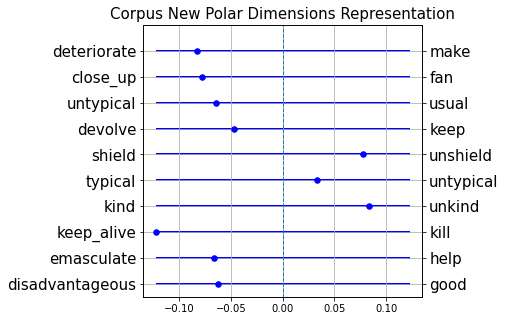

time: 625 ms (started: 2021-12-18 22:18:22 -03:00)


In [18]:
DC.plot_corpus_representation()

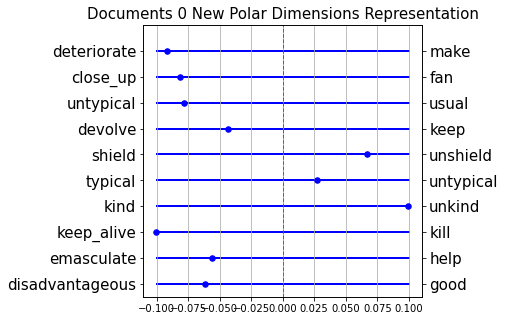

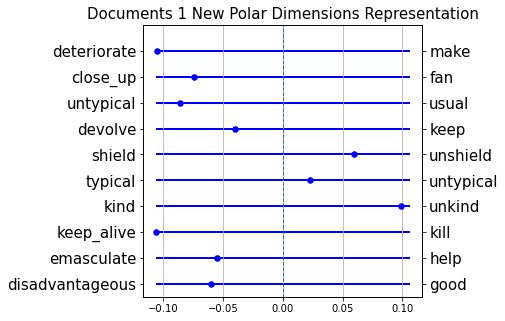

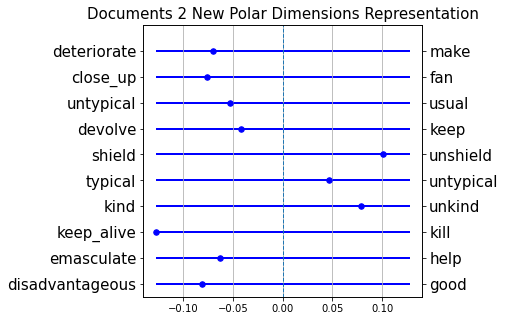

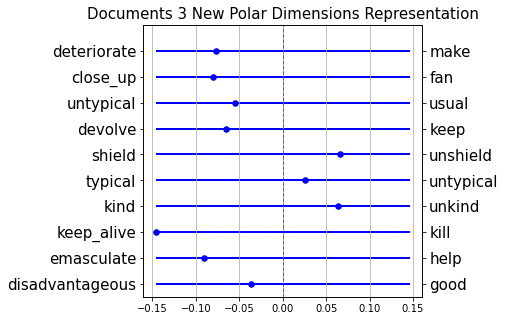

time: 2 s (started: 2021-12-18 22:18:23 -03:00)


In [19]:
DC.plot_document_representation()

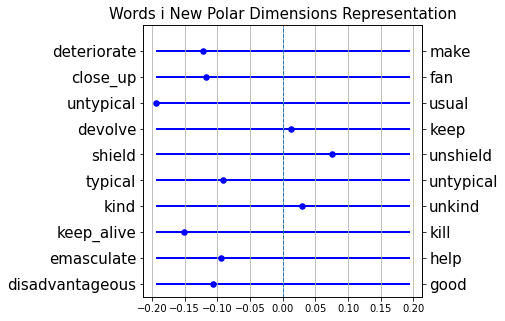

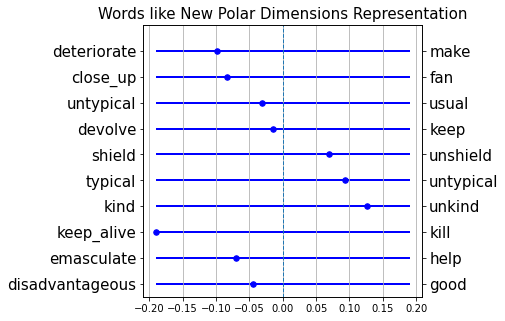

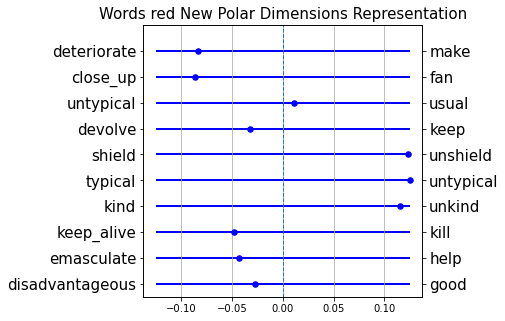

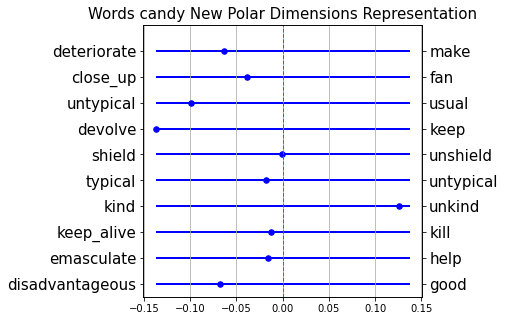

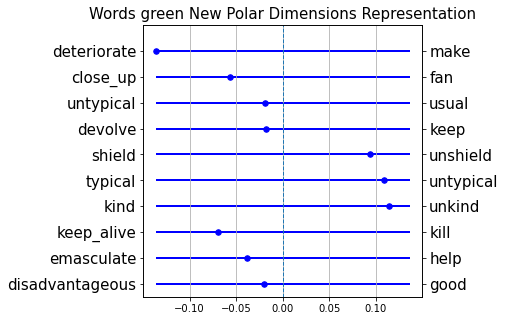

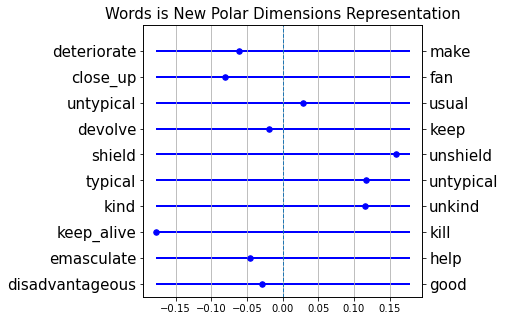

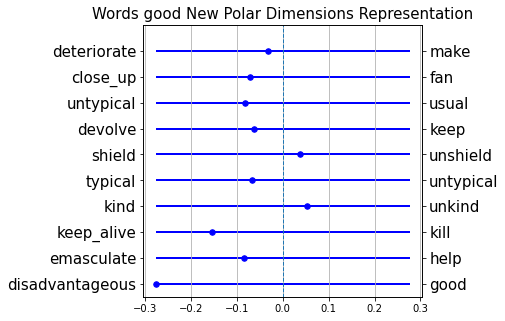

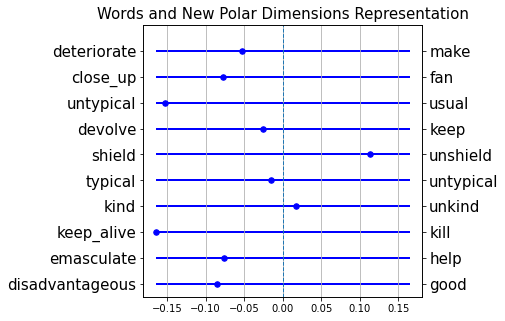

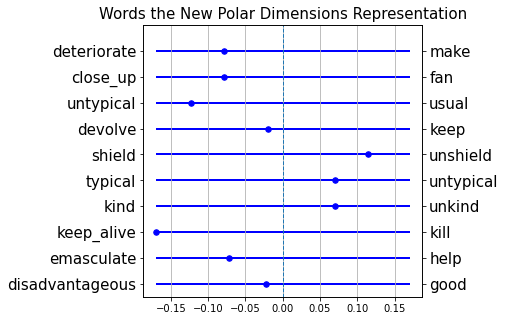

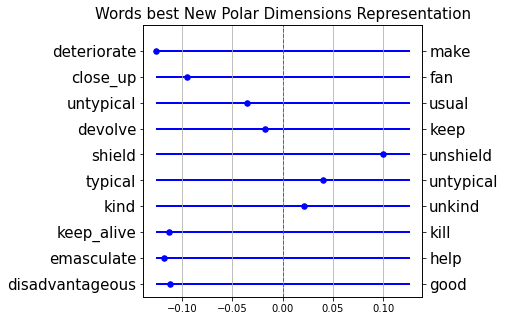

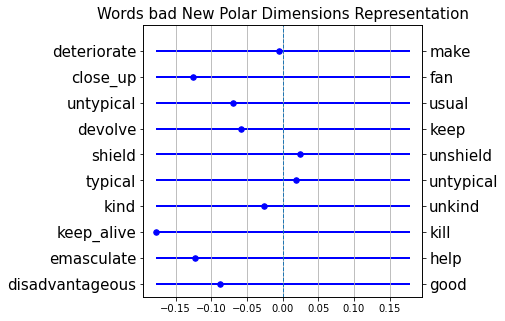

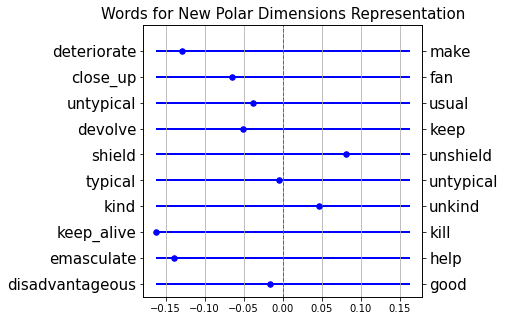

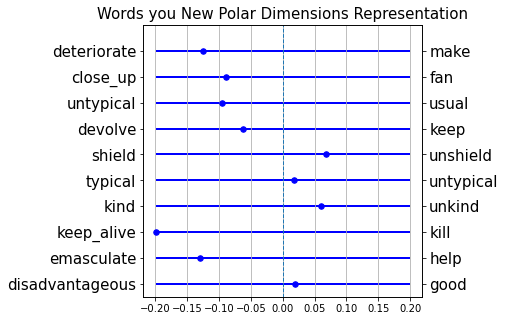

time: 6.44 s (started: 2021-12-18 22:18:25 -03:00)


In [20]:
DC.plot_word_representation()